In [1]:
#https://ieeexplore.ieee.org/document/10549889

In [2]:
!pip install openpyxl ssqueezepy pyt

Defaulting to user installation because normal site-packages is not writeable


In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model, Sequential
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd

2025-01-18 07:18:05.556123: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9360] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-18 07:18:05.556215: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-18 07:18:05.556249: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1537] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-18 07:18:05.566353: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
import keras.models
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [5]:
data = pd.read_csv("WISDM.csv", index_col=0)
data

,user-id,activity,timestamp,X,Y,Z
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164
...,...,...,...,...,...,...
1098199,19,Sitting,131623331483000,9.000000,-1.570000,1.690000
1098200,19,Sitting,131623371431000,9.040000,-1.460000,1.730000
1098201,19,Sitting,131623411592000,9.080000,-1.380000,1.690000
1098202,19,Sitting,131623491487000,9.000000,-1.460000,1.730000


In [6]:
# mapping = {'Walking': 0, 'Jogging': 1, 'Upstairs': 2, 'Downstairs': 3, 'Sitting': 4, 'Standing': 5}

# # 레이블 인코딩
# data['ActivityEncoded'] = data['activity'].map(mapping)
# data

In [7]:
data['X'] = data['X'].astype('float')
data['Y'] = data['Y'].astype('float')
data['X'] = data['Z'].astype('float')

In [8]:
df = data.drop(['user-id', 'timestamp'], axis = 1).copy()
df.head()

,activity,X,Y,Z
0,Jogging,0.503953,12.680544,0.503953
1,Jogging,0.953424,11.264028,0.953424
2,Jogging,-0.081722,10.882658,-0.081722
3,Jogging,3.023717,18.496431,3.023717
4,Jogging,7.205164,12.108489,7.205164


<Axes: xlabel='activity', ylabel='count'>

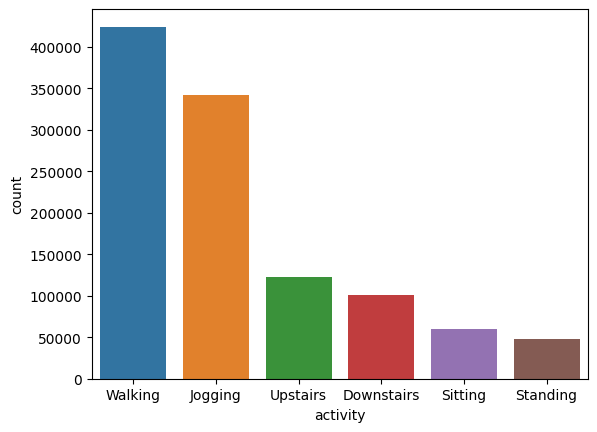

In [9]:
sns.countplot(x = "activity", data = df, order = df.activity.value_counts().index)

In [10]:
df['activity'].value_counts()

Walking       424397
Jogging       342176
Upstairs      122869
Downstairs    100427
Sitting        59939
Standing       48395
Name: activity, dtype: int64

In [11]:
# Sitting = df[df['activity']=='Sitting'].head(48000).copy()
# Standing = df[df['activity']=='Standing'].head(48000).copy()

In [12]:
Sitting = df[df['activity']=='Sitting'].copy()
Standing = df[df['activity']=='Standing'].copy()

In [13]:
static_df = pd.DataFrame()
static_df = pd.concat([static_df, Sitting, Standing])
static_df.shape

(108334, 4)

In [14]:
static_df['activity'].value_counts()

Sitting     59939
Standing    48395
Name: activity, dtype: int64

In [15]:
from sklearn.preprocessing import LabelEncoder

label = LabelEncoder()
static_df['label'] = label.fit_transform(static_df['activity'])
static_df.head()

,activity,X,Y,Z,label
221333,Sitting,1.035146,9.66,1.035146,0
221334,Sitting,0.503953,9.53,0.503953,0
221335,Sitting,0.762740,8.89,0.762740,0
221336,Sitting,0.926184,9.38,0.926184,0
221337,Sitting,1.035146,9.34,1.035146,0


In [16]:
X = static_df[['X', 'Y', 'Z']]
y = static_df['label']

In [17]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

scaled_X = pd.DataFrame(data = X, columns = ['X', 'Y', 'Z'])
scaled_X['label'] = y.values

scaled_X

,X,Y,Z,label
0,-0.683956,1.055281,-0.683956,0
1,-0.811283,1.025586,-0.811283,0
2,-0.749252,0.879393,-0.749252,0
3,-0.710074,0.991322,-0.710074,0
4,-0.683956,0.982184,-0.683956,0
...,...,...,...,...
108329,-1.023165,0.765179,-1.023165,1
108330,-1.032753,0.730915,-1.032753,1
108331,-1.145412,0.790306,-1.145412,1
108332,-1.190955,0.799443,-1.190955,1


In [18]:
from scipy import stats

def create_dataset(X, y, time_steps=1, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        v = X.iloc[i:(i + time_steps)].values
        labels = y.iloc[i: i + time_steps]
        Xs.append(v)
        ys.append(stats.mode(labels)[0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)

TIME_STEPS = 128
STEP = 40

X_data, y_data = create_dataset(scaled_X[["X", "Y", "Z"]], scaled_X.label, TIME_STEPS,
                                  STEP)

trainX, testX,trainy, testy = train_test_split(X_data, y_data, test_size = 0.2, stratify=  y_data )
trainX, valX, trainy, valy  = train_test_split(trainX, trainy, test_size = 0.2, stratify=  trainy )
print(trainX.shape, trainy.shape)
print(testX.shape, testy.shape)

(1731, 128, 3) (1731, 1)
(542, 128, 3) (542, 1)


In [19]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown = "ignore", sparse_output = False)
enc = enc.fit(trainy)

trainy_one_hot = enc.transform(trainy)
testy_one_hot = enc.transform(testy)
valy_one_hot = enc.transform(valy)

print(trainX.shape, trainy_one_hot.shape, testX.shape, testy_one_hot.shape)

(1731, 128, 3) (1731, 2) (542, 128, 3) (542, 2)


In [20]:
unique, counts = np.unique(trainy, return_counts=True)
print ("Train data label statistics::")
print (np.asarray((unique, counts)).T)

unique, counts = np.unique(testy, return_counts=True)
print ("Test data label statistics::")
print (np.asarray((unique, counts)).T)

Train data label statistics::
[[  0 957]
 [  1 774]]
Test data label statistics::
[[  0 300]
 [  1 242]]


In [21]:
X_train_all = trainX   # at this stage, the data includes both dynamic and static HAR data
y_train_all = trainy

X_test_all = testX
y_test_all = testy

# Standard Scaling

In [22]:
# from sklearn.preprocessing import StandardScaler

# # Standard Scaling
# scaler_std = StandardScaler()

# # 데이터 평탄화 후 스케일링
# trainX_flat_std = trainX.reshape(-1, 9)
# testX_flat_std = testX.reshape(-1, 9)

# trainX_std = scaler_std.fit_transform(trainX_flat_std)
# testX_std = scaler_std.transform(testX_flat_std)

# # 원래 형태로 변환
# trainX_std = trainX_std.reshape(4067, 128, 9)
# testX_std = testX_std.reshape(1560, 128, 9)

# print("Standard Scaled trainX shape:", trainX_std.shape)
# print("Standard Scaled testX shape:", testX_std.shape)

In [23]:
trainX_transformer = trainX.copy()
testX_transformer = testX.copy()
valX_transformer = valX.copy()

In [24]:
# from tensorflow.keras import layers, models
# import tensorflow as tf

# def reshape_to_transformer_input(data):
#     """
#     데이터 형태를 Transformer 입력에 맞게 조정
#     Input: (None, 128, 9)
#     Output: (None, 128, 256)
#     """
#     input_layer = layers.Input(shape=(128, 9))
#     x = layers.Conv1D(filters=256, kernel_size=3, strides=1, padding='same')(input_layer)
#     x = layers.LayerNormalization()(x)
    
#     model = tf.keras.Model(inputs=input_layer, outputs=x)
#     return model(data).numpy()

# # 데이터 변환
# trainX_transformer = reshape_to_transformer_input(trainX_minmax)
# testX_transformer = reshape_to_transformer_input(testX_minmax)

# print("Transformer-ready trainX shape:", trainX_transformer.shape)  # (4067, 128, 256)
# print("Transformer-ready testX shape:", testX_transformer.shape)    # (1560, 128, 256)

# ResNet 입력 형태 변환

In [25]:
# ResNet 입력 형태로 변환
trainX_resnet = trainX[..., np.newaxis]  # 마지막 축에 채널 추가
testX_resnet = testX[..., np.newaxis]    # 마지막 축에 채널 추가
valX_resnet = valX[..., np.newaxis]    # 마지막 축에 채널 추가

print("ResNet trainX shape:", trainX_resnet.shape)
print("ResNet testX shape:", testX_resnet.shape)
print("ResNet valX shape:", valX_resnet.shape)

ResNet trainX shape: (1731, 128, 3, 1)
ResNet testX shape: (542, 128, 3, 1)
ResNet valX shape: (433, 128, 3, 1)


# DOLG Model

In [26]:
import tensorflow as tf
from tensorflow.keras import layers

class GeneralizedMeanPooling2D(layers.Layer):
    def __init__(self, init_norm=3.0, normalize=False, epsilon=1e-4, **kwargs):
        self.init_norm = init_norm
        self.normalize = normalize
        self.epsilon = epsilon
        super(GeneralizedMeanPooling2D, self).__init__(**kwargs)

    def build(self, input_shape):
        self.p = self.add_weight(
            name="norms",
            shape=(input_shape[-1],),
            initializer=tf.keras.initializers.Constant(self.init_norm),
            trainable=True
        )
        super(GeneralizedMeanPooling2D, self).build(input_shape)

    def call(self, inputs):
        x = tf.abs(tf.maximum(self.epsilon, inputs))  # 안정성을 위해 epsilon 추가
        x = tf.pow(x, self.p)  # p승
        x = tf.reduce_mean(x, axis=[1, 2], keepdims=False)  # 평균
        x = tf.pow(x, 1.0 / self.p)  # 1/p 승
        
        if self.normalize:
            x = tf.nn.l2_normalize(x, axis=1)
        
        return x

    def get_config(self):
        config = {
            'init_norm': self.init_norm,
            'normalize': self.normalize,
            'epsilon': self.epsilon
        }
        base_config = super(GeneralizedMeanPooling2D, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


In [27]:
from tensorflow.keras import layers

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.3):
    x = inputs
    for _ in range(4):  # 4개의 Transformer Block 반복
        # Multi-Head Attention
        x_attn = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
        x = layers.Add()([x, x_attn])
        x = layers.LayerNormalization(epsilon=1e-3)(x)
        
        # Feed-Forward Network
        x_ff = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
        x_ff = layers.Dropout(dropout)(x_ff)
        x_ff = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x_ff)
        x = layers.Add()([x, x_ff])
        x = layers.LayerNormalization(epsilon=1e-3)(x)
    
    return x


In [28]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling1D, Dense, Lambda

def build_transformer_model(input_shape):
    inputs = Input(shape=input_shape)
    x = transformer_encoder(inputs, head_size=64, num_heads=4, ff_dim=128, dropout=0.3)
    x = GlobalAveragePooling1D()(x)
    outputs = Dense(128, activation='relu')(x)
    return Model(inputs, outputs, name="TransformerEncoder")


In [29]:
def resnet_block(inputs, filters, kernel_size=3, strides=1):
    x = inputs
    for _ in range(4):  # 4개의 ResNet Block 반복
        shortcut = x
        x = layers.Conv2D(filters, kernel_size, strides=strides, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
        x = layers.Conv2D(filters, kernel_size, strides=1, padding='same')(x)
        x = layers.BatchNormalization()(x)
        
        if shortcut.shape[-1] != x.shape[-1]:
            shortcut = layers.Conv2D(filters, kernel_size=1, strides=strides, padding='same')(shortcut)
            shortcut = layers.BatchNormalization()(shortcut)
        
        x = layers.Add()([x, shortcut])
        x = layers.ReLU()(x)
    
    return x


In [30]:
def build_resnet_model_with_gem(input_shape):
    inputs = tf.keras.layers.Input(shape=input_shape)
    
    # ResNet Block 반복
    x = resnet_block(inputs, filters=32)
    x = resnet_block(x, filters=64)
    x = resnet_block(x, filters=128)
    x = resnet_block(x, filters=256)
    x = layers.Dropout(0.3)(x)
    
    # GeM 적용
    x = GeneralizedMeanPooling2D()(x)
    
    # Dense Layer 추가
    outputs = layers.Dense(128, activation='relu')(x)
    
    return tf.keras.Model(inputs, outputs, name="ResNetEncoderWithGeM")


In [31]:
class AttentionFusion(layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(name='AttentionFusion', **kwargs)
        self.attention_dense = layers.Dense(1, activation='sigmoid')  # Compute attention weight

    def call(self, inputs):
        local_feat, global_feat = inputs

        # Concatenate features and compute attention weights
        concat_feat = tf.concat([local_feat, global_feat], axis=1)
        attention_weights = self.attention_dense(concat_feat)  # Shape: (batch_size, 1)

        # Weighted sum of local and global features
        fused = attention_weights * local_feat + (1 - attention_weights) * global_feat
        return fused

In [32]:
from tensorflow.keras.layers import Input, Dense, Dropout, Lambda
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K

def build_dolg_model_with_l2_norm(transformer_input_shape, resnet_input_shape, num_classes):
    # 입력 레이어
    transformer_input = Input(shape=transformer_input_shape, name='Transformer_Input')
    resnet_input = Input(shape=resnet_input_shape, name='ResNet_Input')
    
    # Transformer Branch
    transformer_output = build_transformer_model(transformer_input_shape)(transformer_input)
    transformer_output = Lambda(lambda x: K.l2_normalize(x, axis=-1))(transformer_output)
    
    # ResNet Branch
    resnet_output = build_resnet_model_with_gem(resnet_input_shape)(resnet_input)
    resnet_output = Lambda(lambda x: K.l2_normalize(x, axis=-1))(resnet_output)
    
    # Orthogonal Fusion
    fusion_output = AttentionFusion()([transformer_output, resnet_output])
    fusion_output = Dropout(0.3)(fusion_output)
    fusion_output = Dense(128, activation='relu')(fusion_output)
    fusion_output = Lambda(lambda x: K.l2_normalize(x, axis=-1))(fusion_output)
    
    # Classifier
    outputs = Dense(num_classes, activation='softmax')(fusion_output)
    
    # 모델 생성
    model = Model(inputs=[transformer_input, resnet_input], outputs=outputs, name='DOLG_Model_with_L2_Norm')
    return model

In [33]:
import tensorflow as tf

def focal_loss(alpha=0.25, gamma=3.0):
    """
    Focal Loss 함수
    :param alpha: 클래스 가중치 조정 (기본값 0.25)
    :param gamma: 초점 조정 파라미터 (기본값 2.0)
    :return: 손실 값
    """
    def loss_fn(y_true, y_pred):
        # 예측값의 안정성을 보장하기 위해 작은 값 추가
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)

        # Cross-Entropy Loss 계산
        ce_loss = -y_true * tf.math.log(y_pred)

        # Focal Loss 추가
        fl_loss = alpha * tf.math.pow(1 - y_pred, gamma) * ce_loss
        return tf.reduce_mean(tf.reduce_sum(fl_loss, axis=-1))
    return loss_fn


In [34]:
# import tensorflow as tf

# def categorical_focal_loss(alpha=0.25, gamma=3.0):
#     """
#     원핫 인코딩된 레이블을 사용하는 Focal Loss
#     :param alpha: 클래스 가중치 (0~1 사이의 값, 기본값 0.25)
#     :param gamma: 초점 조정 파라미터 (양수, 기본값 2.0)
#     :return: 손실 값
#     """
#     def loss_fn(y_true, y_pred):
#         # 안정성을 위해 epsilon 추가
#         epsilon = tf.keras.backend.epsilon()
#         y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)

#         # Cross-Entropy 계산
#         ce_loss = -y_true * tf.math.log(y_pred)

#         # Focal Loss 계산
#         fl_loss = alpha * tf.math.pow(1 - y_pred, gamma) * ce_loss

#         # 축(axis=-1) 기준으로 합산
#         return tf.reduce_mean(tf.reduce_sum(fl_loss, axis=-1))
    
#     return loss_fn


In [35]:
# 하이퍼파라미터 설정
num_classes = 2

#alpha = [0.32, 0.306, 0.304]  # 클래스별 가중치

# DOLG 모델 구축
dolg_model = build_dolg_model_with_l2_norm((128, 3), (128, 3, 1), num_classes)

# 모델 컴파일
dolg_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3, clipvalue=1.0),
    loss=focal_loss(alpha=0.25, gamma=3.0),
#     loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 모델 요약
dolg_model.summary()


2025-01-18 07:18:12.457468: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1883] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38698 MB memory:  -> device: 0, name: CUDA GPU, pci bus id: 0000:8c:00.0, compute capability: 8.0
2025-01-18 07:18:12.459945: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1883] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38698 MB memory:  -> device: 1, name: CUDA GPU, pci bus id: 0000:cc:00.0, compute capability: 8.0


Model: "DOLG_Model_with_L2_Norm"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Transformer_Input (InputLa  [(None, 128, 3)]             0         []                            
 yer)                                                                                             
                                                                                                  
 ResNet_Input (InputLayer)   [(None, 128, 3, 1)]          0         []                            
                                                                                                  
 TransformerEncoder (Functi  (None, 128)                  19528     ['Transformer_Input[0][0]']   
 onal)                                                                                            
                                                                            

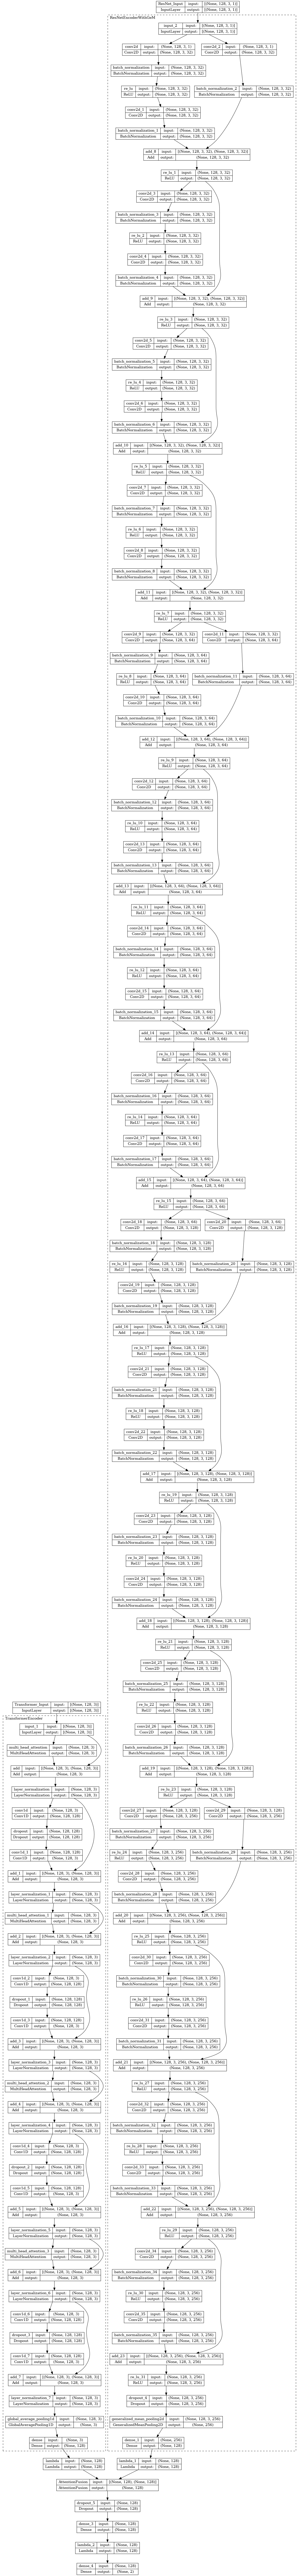

In [36]:
from tensorflow.keras.utils import plot_model

# 모델 시각화
plot_model(
    dolg_model,                   # 학습에 사용된 모델
    to_file="model_plot.png",  # 저장할 파일 이름
    show_shapes=True,         # 각 레이어의 출력 텐서 모양 표시
    show_layer_names=True,    # 레이어 이름 표시
    expand_nested=True,       # 중첩된 모델 (서브모델) 시각화
    dpi=96                    # 해상도 설정
)

In [37]:
trainX_transformer.shape

(1731, 128, 3)

In [38]:
trainX_resnet.shape

(1731, 128, 3, 1)

In [39]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.utils import class_weight
from tensorflow.keras.callbacks import LearningRateScheduler

def lr_schedule(epoch, lr):
    if epoch < 5:
        return lr
    return lr * tf.math.exp(-0.05)  # 지수 감소

lr_scheduler = LearningRateScheduler(lr_schedule)

# ReduceLROnPlateau 설정
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # 검증 손실 기준으로 동작
    factor=0.5,          # 학습률 감소 비율 (50% 감소)
    patience = 5,          # 개선되지 않을 경우 5 Epoch 후 학습률 감소
    min_lr=1e-6          # 학습률의 하한선
)

# EarlyStopping 설정
early_stopping = EarlyStopping(
    monitor='val_loss',     # 검증 손실 기준으로 조기 종료
    patience=10,            # 개선되지 않을 경우 10 Epoch 후 종료
    restore_best_weights=True  # 가장 좋은 가중치로 복원
)

# # 클래스 가중치 계산
# class_weights = class_weight.compute_class_weight(
#     class_weight='balanced',
#     classes=np.unique(np.argmax(trainy_one_hot, axis=1)),
#     y=np.argmax(trainy_one_hot, axis=1)
# )

# class_weights = {i: w for i, w in enumerate(class_weights)}
# print("Class Weights:", class_weights)

# 콜백 리스트
callbacks = [early_stopping, reduce_lr, lr_scheduler]
# callbacks = [early_stopping, lr_scheduler]
# callbacks = [early_stopping, reduce_lr]

# 모델 학습
history = dolg_model.fit(
    [trainX_transformer, trainX_resnet],  # 입력 데이터
    trainy_one_hot,                       # 레이블
    validation_data = ([valX_transformer, valX_resnet],
    valy_one_hot),                # 검증 데이터
    epochs=100,                          # 최대 Epoch 수
    batch_size=32,                       # 배치 사이즈
    callbacks=callbacks                  # 콜백 리스트 추가
)

Epoch 1/100


2025-01-18 07:18:27.511579: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1021] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inDOLG_Model_with_L2_Norm/ResNetEncoderWithGeM/dropout_4/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-01-18 07:18:29.521006: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2025-01-18 07:18:31.848374: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fa17486a720 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-01-18 07:18:31.848402: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): CUDA GPU, Compute Capability 8.0
2025-01-18 07:18:31.848409: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): CUDA GPU, Compute Capability 8.0
2025-01-18 07:18:31.853086: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling M

55/55 [==============================] - 35s 104ms/step - loss: 0.0064 - accuracy: 0.9486 - val_loss: 0.0038 - val_accuracy: 0.9746 - lr: 0.0010
Epoch 2/100
55/55 [==============================] - 3s 52ms/step - loss: 0.0042 - accuracy: 0.9711 - val_loss: 0.0044 - val_accuracy: 0.9677 - lr: 0.0010
Epoch 3/100
55/55 [==============================] - 3s 53ms/step - loss: 0.0042 - accuracy: 0.9717 - val_loss: 0.0035 - val_accuracy: 0.9746 - lr: 0.0010
Epoch 4/100
55/55 [==============================] - 3s 51ms/step - loss: 0.0055 - accuracy: 0.9509 - val_loss: 0.0052 - val_accuracy: 0.9400 - lr: 0.0010
Epoch 5/100
55/55 [==============================] - 3s 51ms/step - loss: 0.0045 - accuracy: 0.9642 - val_loss: 0.0050 - val_accuracy: 0.9677 - lr: 0.0010
Epoch 6/100
55/55 [==============================] - 3s 55ms/step - loss: 0.0045 - accuracy: 0.9648 - val_loss: 0.0036 - val_accuracy: 0.9792 - lr: 9.5123e-04
Epoch 7/100
55/55 [==============================] - 3s 52ms/step - loss: 0.

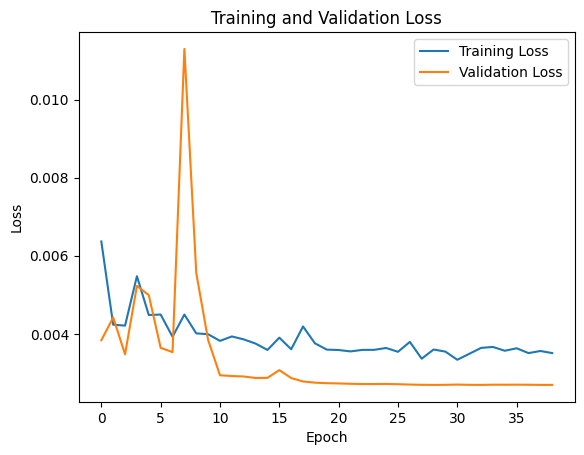

In [40]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

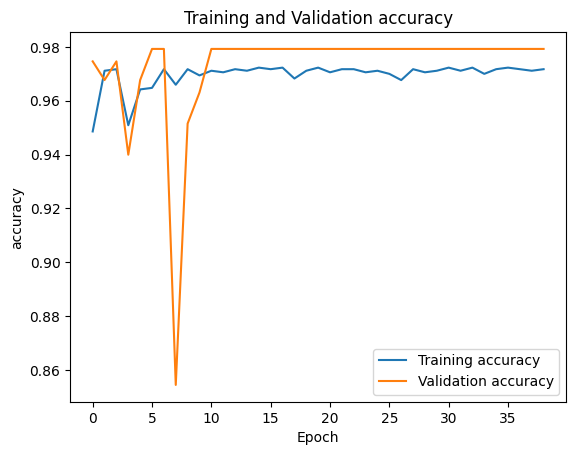

In [41]:
# Plot training and validation loss
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend()
plt.title('Training and Validation accuracy')
plt.show()

17/17 [==============================] - 1s 22ms/step
Classification Report:
              precision    recall  f1-score   support

     SITTING       1.00      0.98      0.99       300
    STANDING       0.97      1.00      0.99       242

    accuracy                           0.99       542
   macro avg       0.99      0.99      0.99       542
weighted avg       0.99      0.99      0.99       542

Test Accuracy: 0.99


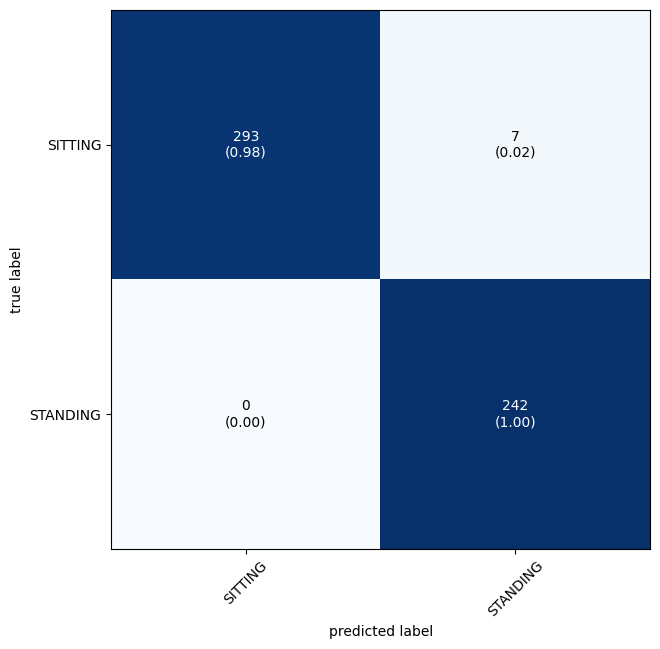

In [42]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import numpy as np

# 예측 수행
predy = dolg_model.predict([testX_transformer, testX_resnet])
predy = np.argmax(predy, axis=-1)  # 가장 확률이 높은 클래스를 선택

# 테스트 라벨 (One-Hot Encoding → 정수형 라벨 변환)
testy = np.argmax(testy_one_hot, axis=-1)  # 테스트 레이블 변환

# 라벨 정의
LABELS = ['SITTING', 'STANDING']

# 혼동 행렬 생성
cm = confusion_matrix(testy, predy)

# 혼동 행렬 시각화
plot_confusion_matrix(conf_mat=cm, class_names=LABELS, show_normed=True, figsize=(7,7))

# 성능 보고서 출력
print("Classification Report:")
print(classification_report(testy, predy, target_names=LABELS))

# 정확도 출력
accuracy = accuracy_score(testy, predy)
print(f"Test Accuracy: {accuracy:.2f}")


In [43]:
from sklearn.metrics import precision_score, recall_score, f1_score

print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))

[[293   7]
 [  0 242]]
0.9870848708487084
0.9871007063123732
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       300
           1       0.97      1.00      0.99       242

    accuracy                           0.99       542
   macro avg       0.99      0.99      0.99       542
weighted avg       0.99      0.99      0.99       542

